<a href="https://colab.research.google.com/github/PCBZ/CS6140/blob/main/HW3/HW3_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Model: Bernoulli
Fold	FP Rate	FN Rate	Error Rate
1	0.0287	0.1429	0.0738
2	0.0360	0.1813	0.0935
3	0.0432	0.1154	0.0717
4	0.0394	0.1602	0.0870
5	0.0502	0.1878	0.1043
6	0.0824	0.2320	0.1413
7	0.0681	0.1878	0.1152
8	0.0573	0.1657	0.1000
9	0.0753	0.1105	0.0891
10	0.0609	0.1381	0.0913
Avg	0.0542	0.1622	0.0967
Accuracy:  90.33%

Model: Gaussian
Fold	FP Rate	FN Rate	Error Rate
1	0.0753	0.1044	0.0868
2	0.0755	0.1484	0.1043
3	0.0863	0.1099	0.0957
4	0.0573	0.1492	0.0935
5	0.0681	0.1381	0.0957
6	0.1147	0.1657	0.1348
7	0.0789	0.1547	0.1087
8	0.1147	0.0994	0.1087
9	0.0860	0.1713	0.1196
10	0.1219	0.1050	0.1152
Avg	0.0879	0.1346	0.1063
Accuracy:  89.37%

Model: Histogram
Fold	FP Rate	FN Rate	Error Rate
1	0.0394	0.1429	0.0803
2	0.0360	0.2033	0.1022
3	0.0540	0.0989	0.0717
4	0.0466	0.1823	0.1000
5	0.0430	0.1823	0.0978
6	0.0645	0.2265	0.1283
7	0.0538	0.2155	0.1174
8	0.0609	0.1713	0.1043
9	0.0753	0.1271	0.0957
10	0.0466	0.1547	0.0891
Avg	0.0520	0.1705	0.0987
Accuracy:  90.13%


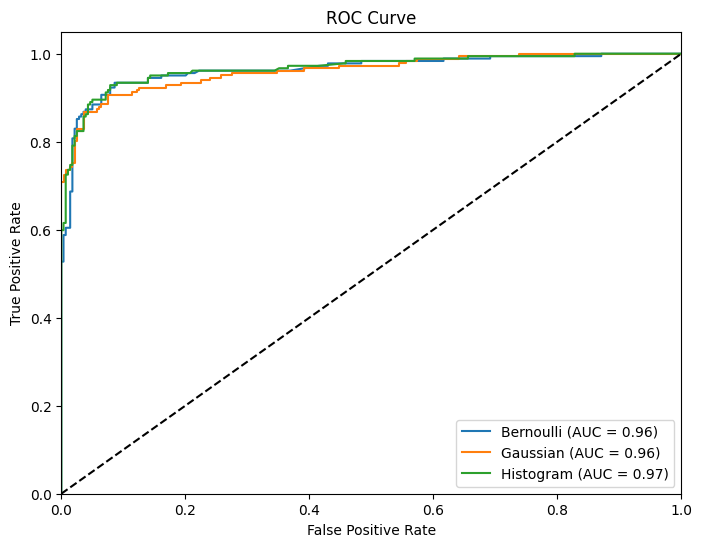

In [15]:
%pip install ucimlrepo

import numpy as np
from ucimlrepo import fetch_ucirepo
from abc import ABC, abstractmethod
from scipy.stats import norm
from functools import reduce
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class AbstractNaiveBayesClassifier(ABC):
    """
    An abstract base class for Naive Bayes classifiers.
    """
    def __init__(self, laplace_smoothing=1.0):
        self.laplace_smoothing = laplace_smoothing
        self.classes = None
        self.class_priors = None
        self.feature_likelihoods = None

    def __str__(self):
        return self.__class__.__name__

    def fit(self, X, y):
        """
        Train the Naive Bayes classifier on the given training data.
        """
        n_samples = len(y)
        self.classes = np.unique(y)
        n_features = X.shape[1]

        # Calculate prior probablities with Laplace smooting
        self.class_priors = {
            c: (np.sum(y == c) + self.laplace_smoothing) / (n_samples + len(self.classes) * self.laplace_smoothing)
            for c in self.classes
        }

        # Fit each features
        self._fit_features(X, y, n_features)

    @abstractmethod
    def _fit_features(self, X, y, n_features):
        """
        Fit the features of the Naive Bayes classifier.
        """
        pass

    @abstractmethod
    def _calculate_likelihood(self, x, feature_idx, class_label):
        """
        Calculate the likelihood of a feature value given a class label.
        """
        pass

    def predict_log_odds(self, X):
        """
        Calculate the log odds of each class for each sample in X.
        """
        n_samples = X.shape[0]

        def calculate_log_odds(sample_idx):
            # Initial value log(P(Spam) / P(NonSpam))
            initial = np.log(self.class_priors[1] / self.class_priors[0])

            def add_feature_log_odds(accumulation, feature_idx):
                prob_spam = self._calculate_likelihood(X[sample_idx, feature_idx], feature_idx, 1)
                prob_non_spam = self._calculate_likelihood(X[sample_idx, feature_idx], feature_idx, 0)

                # Add a small epsilon to prevent division by zero
                epsilon = 1e-10
                return accumulation + np.log((prob_spam + epsilon) / (prob_non_spam + epsilon))

            # Add log likelihood for each features
            return reduce(add_feature_log_odds, range(X.shape[1]), initial)

        return np.array(list(map(calculate_log_odds, range(n_samples))))


    def predict(self, X, threshold = 0):
        """
        Predict the class labels for each sample in X.
        """
        log_odds = self.predict_log_odds(X)
        return (log_odds > threshold).astype(int)

class BernoulliNaiveBayesClassifier(AbstractNaiveBayesClassifier):
    """
    Naive Bayes classifier for binary features.
    """

    def __str__(self):
        return "Bernoulli"

    def _fit_features(self, X, y, n_features):
        self.feature_means = np.mean(X, axis=0)
        self.feature_likelihoods = {
            c: {
                feature_idx: (np.sum(X[y == c, feature_idx] > self.feature_means[feature_idx]) + self.laplace_smoothing) / (len(X[y == c]) + 2 * self.laplace_smoothing)
                for feature_idx in range(n_features)
            }
            for c in self.classes
        }

    def _calculate_likelihood(self, x, feature_idx, class_label):
        prob_greater = self.feature_likelihoods[class_label][feature_idx]
        prob_less = 1 - prob_greater
        if x > self.feature_means[feature_idx]:
            return prob_greater
        else:
            return prob_less

class GaussianNaiveBayesClassifier(AbstractNaiveBayesClassifier):
    """
    Naive Bayes classifier for continuous features.
    """
    def __str__(self):
        return "Gaussian"

    def fit(self, X, y):
        """
        Train the Naive Bayes classifier on the given training data.
        """
        super().fit(X, y)
        self._find_optimal_threshold(X, y)

    def _fit_features(self, X, y, n_features):
        self.feature_likelihoods = {
            c: {
                feature_idx: (np.mean(X[y == c, feature_idx]), np.var(X[y == c, feature_idx]) + 1e-9)
                for feature_idx in range(n_features)
            }
            for c in self.classes
        }

    def _find_optimal_threshold(self, X, y):
        """
        Find the optimal threshold for binary classification.
        """
        log_odds = self.predict_log_odds(X)
        fpr, tpr, thresholds = roc_curve(y, log_odds)
        optimal_idx = np.argmax(tpr - fpr)
        self.optimal_threshold = thresholds[optimal_idx]

    def predict(self, X, threshold = 0):
        """
        Predict the class labels for each sample in X.
        """
        threshold = self.optimal_threshold
        return super().predict(X, threshold)

    def _calculate_likelihood(self, x, feature_idx, class_label):
        mean, var = self.feature_likelihoods[class_label][feature_idx]
        return norm.pdf(x, mean, np.sqrt(var))

class HistogramNaiveBayesClassifier(AbstractNaiveBayesClassifier):
    """
    Naive Bayes classifier for discrete features.
    """
    def __str__(self):
        return "Histogram"

    def _fit_features(self, X, y, n_features):
        self.feature_likelihoods = {}

        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]

            min_val = np.min(feature_values)
            max_val = np.max(feature_values)
            mean_val = np.mean(feature_values)

            spam_mean = np.mean(X[y == 1, feature_idx])
            non_spam_mean = np.mean(X[y == 0, feature_idx])

            low_mean, high_mean = min(spam_mean, non_spam_mean), max(spam_mean, non_spam_mean)

            # Create bins boundaries
            bins = [min_val, low_mean, mean_val, high_mean, max_val]

            # Calculate probabilities for each bin
            for c in self.classes:
                if c not in self.feature_likelihoods:
                    self.feature_likelihoods[c] = {}
                X_c = X[y == c, feature_idx]
                n_c = len(X_c)
                bin_counts = np.histogram(X_c, bins=bins)[0]

                # Apply Laplace smoothing
                bin_probs = (bin_counts + self.laplace_smoothing) / (n_c + len(bin_counts) * self.laplace_smoothing)

                self.feature_likelihoods[c][feature_idx] = (bins, bin_probs)

    def _calculate_likelihood(self, x, feature_idx, class_label):
        bins, bin_probs = self.feature_likelihoods[class_label][feature_idx]
        bin_idx = np.digitize(x, bins[1:-1])
        return bin_probs[bin_idx]

def fetch_spambase_data():
    """
    Fetch Spambase dataset from UCI repository
    Returns:
    --------
    X : numpy array
        Features
    y : numpy array
        Targets
    """
    spambase = fetch_ucirepo(id=94)
    # Extract features and targets
    X = spambase.data.features.values
    y = spambase.data.targets.values.ravel()
    return X, y

def create_folds(X, y, n_folds = 10):
    """
    Create folds as specified: Group k contains points {k, k+10, k+20, ...}
    """
    n_samples = len(y)

    test_indices = [list(range(k, n_samples, n_folds)) for k in range(n_folds)]
    train_indices = [list(set(range(n_samples)) - set(test_idx)) for test_idx in test_indices]

    return [
        {
            'train': (X[train_idx], y[train_idx]),
            'test': (X[test_idx], y[test_idx])
        }
        for train_idx, test_idx in zip(train_indices, test_indices)
    ]

def evaluate_error_tables(model, X_train, y_train, X_test, y_test):
    """
    Train model and calculate error tables
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # False positive: non-spam (0) classified as spam (1)
    fp = np.sum((y_test == 0) & (y_pred == 1))
    total_non_spam = np.sum(y_test == 0)
    fpr = fp / total_non_spam if total_non_spam > 0 else 0

    # False negative: spam (1) classified as non-spam (0)
    fn = np.sum((y_test == 1) & (y_pred == 0))
    total_spam = np.sum(y_test == 1)
    fnr = fn / total_spam if total_spam > 0 else 0

    # Overall error
    overall_error = (fp + fn) / len(y_test)

    return fpr, fnr, overall_error

def create_roc_curve(model, X_test, y_test):
    """
    Create ROC curve data
    """
    y_score = model.predict_log_odds(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def run_experiment(X, y):
    """
    Run experiment on Spambase dataset
    """
    models = [BernoulliNaiveBayesClassifier(), GaussianNaiveBayesClassifier(), HistogramNaiveBayesClassifier()]
    # Create folds
    folds = create_folds(X, y)

    # Set result
    results = {
        name: {"fp_rates" : [], "fn_rates": [], "overall_errors": []}
        for name in map(str, models)
    }

    # Cross Validation
    for fold_idx, fold in enumerate(folds):
        X_train, y_train = fold['train']
        X_test, y_test = fold['test']

        for model in models:
            fpr, fnr, overall_error = evaluate_error_tables(model, X_train, y_train, X_test, y_test)

            results[str(model)]["fp_rates"].append(fpr)
            results[str(model)]["fn_rates"].append(fnr)
            results[str(model)]["overall_errors"].append(overall_error)

    # Show error tables
    for model_name, model_result in results.items():
        print("\n" + "="*50)
        print(f"Model: {model_name}")
        print("="*50)
        print("Fold\tFP Rate\tFN Rate\tError Rate")
        for i in range(10):
            print(f"{i+1}\t{results[model_name]['fp_rates'][i]:.4f}\t"
                  f"{results[model_name]['fn_rates'][i]:.4f}\t"
                  f"{results[model_name]['overall_errors'][i]:.4f}")
        print(f"Avg\t{np.mean(results[model_name]['fp_rates']):.4f}\t"
              f"{np.mean(results[model_name]['fn_rates']):.4f}\t"
              f"{np.mean(results[model_name]['overall_errors']):.4f}")
        avg_accuracy = (1 - np.mean(results[model_name]['overall_errors'])) * 100
        print(f"Accuracy: {avg_accuracy : .2f}%")

    # Generate ROC curve for Fold 1
    plt.figure(figsize=(8, 6))

    X_train, y_train = folds[0]['train']
    X_test, y_test = folds[0]['test']

    for model in models:
        model.fit(X_train, y_train)
        fpr, tpr, roc_auc = create_roc_curve(model, X_test, y_test)

        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    # Fetch data
    X, y = fetch_spambase_data()

    # Run experiment
    run_experiment(X, y)